In [33]:
#LIBRARIES
import os
import git

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [4]:
#LOAD DATA
# Function to load dataset from githun
def get_git_root(path) -> str:
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root


git_dir = get_git_root(os.getcwd()) # Github folder where dataset is storaged.
data_dir = os.path.join(git_dir, "data") # Data folder

# Import dataset to a DataFrame
df_train = pd.read_csv(os.path.join(data_dir, "train.csv")) # [!] main dataset to be analyzed
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [5]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [11]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.882876
Kurtosis: 6.536282


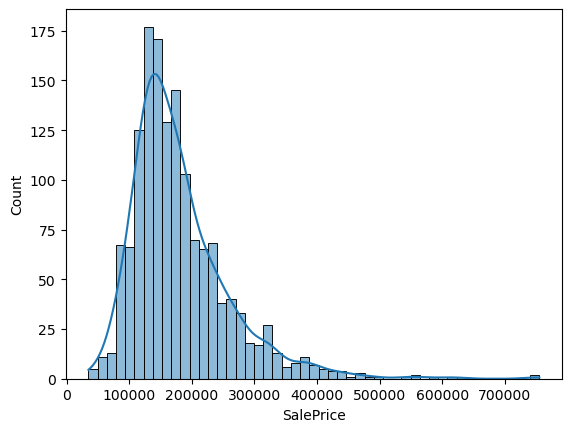

In [16]:
sns.histplot(df_train['SalePrice'], kde=True);
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

In [20]:
#FILL MISSING VALUES AND CHECK AGAIN

columns_with_missing_values = df_train.columns[df_train.notnull().sum() < len(df_train)].tolist()
print('#### LIST OF COLUMNS WITH MISSING VALUES ####')
print(columns_with_missing_values)

print(f'\nTotal quantity of columns with missing values: {len(columns_with_missing_values)}')

df_train_missing_values = df_train[columns_with_missing_values].copy()

df_train_missing_values.info()

#Split "columns_with_missing_values" in 3 different groups, each one with different methods of filling missing values 
fill_with_none = columns_with_missing_values #Create a new list with all columns that will be filled with none, but before fill the other 2 groups must be removed from this list

fill_with_not_answered = ['MasVnrType', 'Electrical'] #Remove columns that will be filled as "not answered" instead of "none"
for column in fill_with_not_answered:
    if column in fill_with_not_answered:
        fill_with_none.remove(column)

fill_with_zero = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'] #Remove columns that will be filled with ZERO instead of "none"
for column in fill_with_zero:
    if column in fill_with_none:
        fill_with_none.remove(column)
#END OF Split "columns_with_missing_values" in 3 different groups, each one with different methods of filling missing values 

#Print these lists to check
print('### Columns to be filled with none:')
print(fill_with_none)
print('\n### Columns to be filled with zeros:')
print(fill_with_not_answered)
print('\n### Columns to be filled with zeros:')
print(fill_with_zero)
print('\n### Total columns to be filled:')
total_columns = len(fill_with_none) + len(fill_with_not_answered) + len(fill_with_zero)
print(total_columns)
#END OF Print these lists to check



#Fill missing values and create a new dataframe to do not affect the original one
df_train_filled = df_train.copy()  # Cria uma cópia do dataframe original

df_train_filled[fill_with_none] = df_train_filled[fill_with_none].fillna("none")
df_train_filled[fill_with_not_answered] = df_train_filled[fill_with_not_answered].fillna("not answered")
df_train_filled[fill_with_zero] = df_train_filled[fill_with_zero].fillna(0)
#END OF Fill missing values and create a new dataframe to do not affect the original one

#Check if the new dataframe still has any missing data.
columns_with_missing_values_2 = df_train_filled .columns[df_train_filled .notnull().sum() < len(df_train_filled )].tolist()
print('#### LIST OF COLUMNS WITH MISSING VALUES ON NEW DATAFRAME####')
print(columns_with_missing_values_2)
print(f'\nTotal quantity of columns with missing values: {len(columns_with_missing_values_2)}')
#END OF Check if the new dataframe still has any missing data.

#### LIST OF COLUMNS WITH MISSING VALUES ####
['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Total quantity of columns with missing values: 19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   

In [22]:
# Separar as colunas numéricas e categóricas
numeric_columns = df_train_filled.select_dtypes(include='number').columns
categorical_columns = df_train_filled.select_dtypes(include='object').columns

# Converter as colunas categóricas em numéricas
df_train_filled_encoded = df_train_filled.copy()
for column in categorical_columns:
    le = LabelEncoder()
    df_train_filled_encoded[column] = le.fit_transform(df_train_filled_encoded[column])

# Definir as features e o target
X = df_train_filled_encoded.drop("SalePrice", axis=1)
y = df_train_filled_encoded["SalePrice"]

# Treinar um modelo de regressão
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Obter a importância das features
importances = model.feature_importances_

# Criar um dataframe com as importâncias das features
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Exibir as colunas com maior importância para SalePrice
top_features = feature_importances.head(12)  # Exemplo: top 12 colunas
print(top_features)


         Feature  Importance
17   OverallQual    0.578882
46     GrLivArea    0.109153
38   TotalBsmtSF    0.036942
44      2ndFlrSF    0.034007
34    BsmtFinSF1    0.029519
61    GarageCars    0.024332
43      1stFlrSF    0.024279
62    GarageArea    0.012665
4        LotArea    0.012614
19     YearBuilt    0.008113
49      FullBath    0.008113
54  TotRmsAbvGrd    0.007364


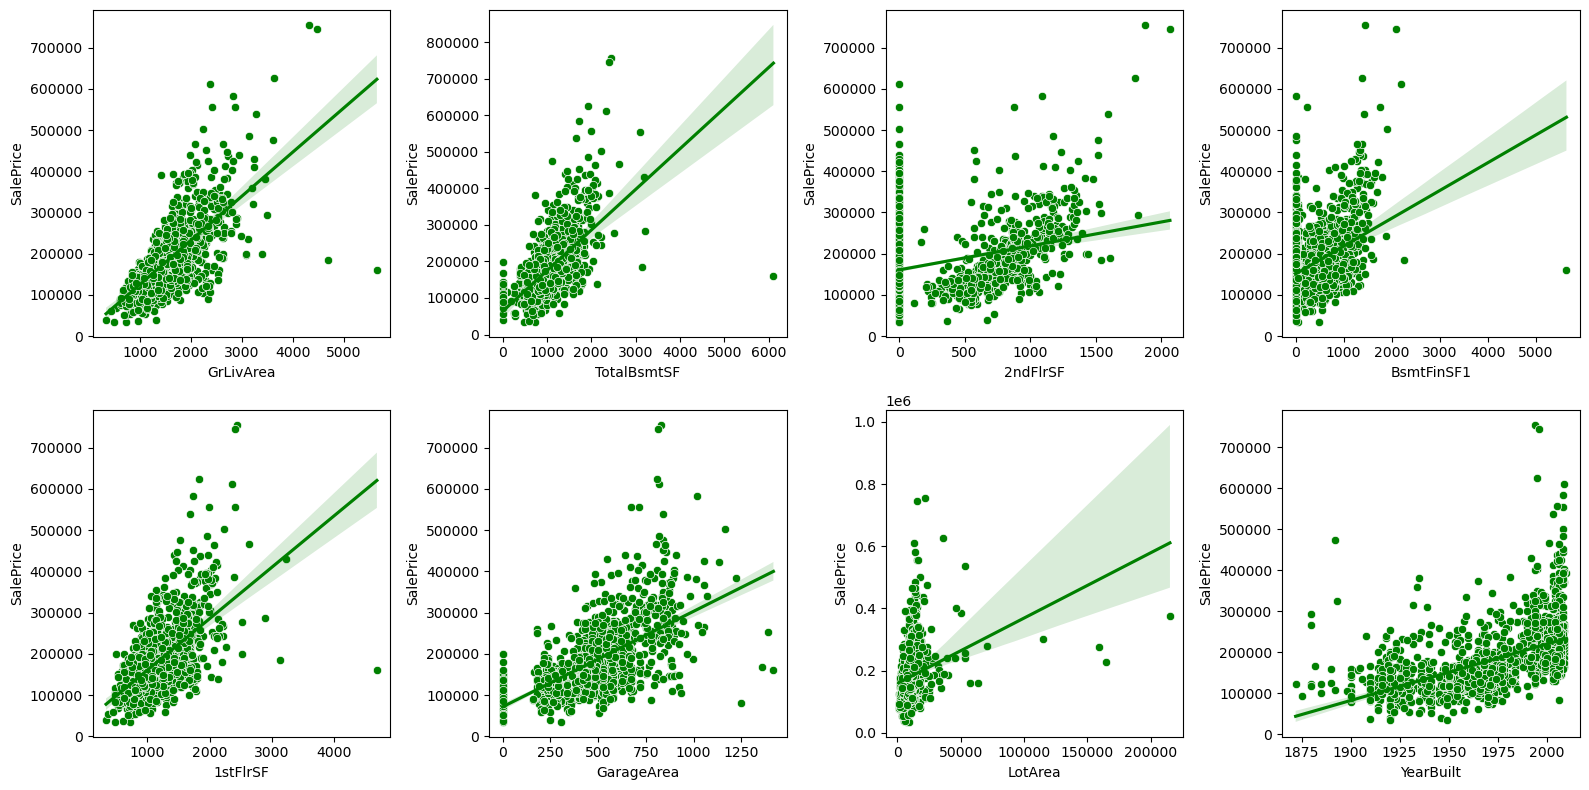

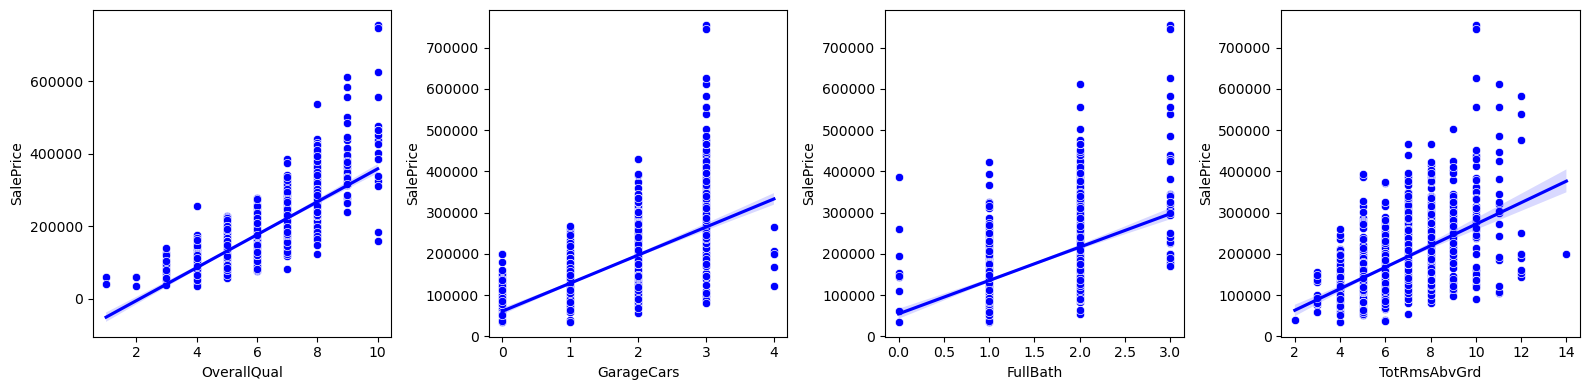

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir as colunas para a primeira matriz
columns1 = ['GrLivArea', 'TotalBsmtSF', '2ndFlrSF', 'BsmtFinSF1', '1stFlrSF', 'GarageArea', 'LotArea', 'YearBuilt']
# Definir as colunas para a segunda matriz
columns2 = ['OverallQual', 'GarageCars', 'FullBath', 'TotRmsAbvGrd']

# Criar a primeira matriz de gráficos
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Percorrer as colunas da primeira matriz
for i, column in enumerate(columns1):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    sns.scatterplot(x=column, y='SalePrice', data=df_train_filled_encoded, ax=ax, color='green')
    sns.regplot(x=column, y='SalePrice', data=df_train_filled_encoded, ax=ax, scatter=False, color='green')
    ax.set_xlabel(column)
    ax.set_ylabel('SalePrice')

# Ajustar o espaçamento entre os subplots da primeira matriz
plt.tight_layout()

# Criar a segunda matriz de gráficos
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Percorrer as colunas da segunda matriz
for i, column in enumerate(columns2):
    ax = axs[i]
    sns.scatterplot(x=column, y='SalePrice', data=df_train_filled_encoded, ax=ax, color='blue')
    sns.regplot(x=column, y='SalePrice', data=df_train_filled_encoded, ax=ax, scatter=False, color='blue')
    ax.set_xlabel(column)
    ax.set_ylabel('SalePrice')

# Ajustar o espaçamento entre os subplots da segunda matriz
plt.tight_layout()

# Exibir as matrizes de gráficos
plt.show()


In [35]:


# Selecionar as colunas para as variáveis independentes
X1 = df_train[columns1]
X2 = df_train_filled_encoded[columns2]

# Variável dependente
y = df_train['SalePrice']

# Dividir os dados em treino e teste
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.2, random_state=42)

# Criar um modelo de regressão linear
model = LinearRegression()

# Treinar o modelo com as colunas 1
model.fit(X1_train, y_train)

# Realizar as previsões com as colunas 1
y_pred1 = model.predict(X1_test)



# Valores de SalePrice do dataframe df_train
sale_price_values = df_train['SalePrice'].values

# Cálculo da média e desvio padrão de SalePrice
sale_price_mean = np.mean(sale_price_values)
sale_price_std = np.std(sale_price_values)

# Definir limiar para determinar se o MSE é bom ou ruim
limiar = sale_price_std  # Pode ser ajustado conforme necessário



# Calcular o erro quadrático médio para as previsões com as colunas 1
mse1 = mean_squared_error(y_test, y_pred1)
print(f"Erro Quadrático Médio (Colunas 1): {mse1}")

# Comparar o MSE com o limiar
if mse1 < limiar:
    print("O MSE é considerado bom em relação à variabilidade de SalePrice.")
else:
    print("O MSE é considerado ruim em relação à variabilidade de SalePrice.")



# Treinar o modelo com as colunas 2
model.fit(X2_train, y_train)

# Realizar as previsões com as colunas 2
y_pred2 = model.predict(X2_test)

# Calcular o erro quadrático médio para as previsões com as colunas 2
mse2 = mean_squared_error(y_test, y_pred2)
print(f"Erro Quadrático Médio (Colunas 2): {mse2}")

# Comparar o MSE com o limiar
if mse2 < limiar:
    print("O MSE é considerado bom em relação à variabilidade de SalePrice.")
else:
    print("O MSE é considerado ruim em relação à variabilidade de SalePrice.")






Erro Quadrático Médio (Colunas 1): 1830323471.120684
O MSE é considerado ruim em relação à variabilidade de SalePrice.
Erro Quadrático Médio (Colunas 2): 2165050753.8354735
O MSE é considerado ruim em relação à variabilidade de SalePrice.
